In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf  
from sklearn.metrics import accuracy_score
from keras.models import Sequential  
from keras.layers import Dense 
from keras.optimizers import Adam, RMSprop

With these preparations, `MLPClassifier` from scikit-learn can be imported and straightforwardly applied.3 “MLP” in this context stands for `multi-layer perceptron`, which is `another expression` for `dense neural network`. As before, the API to apply neural networks with scikit-learn is basically the same:

In [5]:
# from sklearn.neural_network import MLPClassifier
# model = MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [6]:
# Pull raw data
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv', index_col=0, parse_dates=True).dropna()

# Add GLD data from raw
symbol = 'EUR='
data = pd.DataFrame(raw[symbol])
data.rename(columns={symbol: 'price'}, inplace=True)
data['return'] = np.log(data['price'] / data['price'].shift(1))
data.dropna(inplace=True)
data['direction'] = np.where(data['return'] > 0, 1, 0)

# lagging 5 days
lags = 5

# Construct data
cols = []  
for lag in range(1, lags + 1):
    col = 'lag_{}'.format(lag)  
    data[col] = data['return'].shift(lag)  
    cols.append(col)  

data.dropna(inplace=True) 

In [7]:
data.tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810
2019-12-30,1.1197,0.001967,1,0.007094,0.000811,0.000090,0.000722,-0.003784
2019-12-31,1.1210,0.001160,1,0.001967,0.007094,0.000811,0.000090,0.000722


In [8]:
# Set random seed:
def set_seeds(seed = 123):
    # random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

## Set up model

In [9]:
optimizer = Adam(learning_rate = 0.0001)

2025-04-01 05:05:37.236338: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/root/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Construct training and test data

In [17]:
cutoff = '2017-12-31'

# Training data
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()

# Normalizes the features data by Gaussian normalization
training_data_ = (training_data - mu) / std

In [18]:
# Test data
test_data = data[data.index >= cutoff].copy()

# Normalizes the features data by Gaussian normalization
test_data_ = (test_data - mu) / std  

In [19]:
%%time 
model.fit(training_data[cols], training_data['direction'], epochs=50, verbose=True,
          validation_split = 0.2, shuffle=False)
# verbose=True hoặc verbose=1: In progress bar ra màn hình cho từng epoch 
# (rất phổ biến khi huấn luyện model).

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4739 - loss: 0.6932 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5079 - loss: 0.6931 - val_accuracy: 0.4900 - val_loss: 0.6932
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5237 - loss: 0.6931 - val_accuracy: 0.4677 - val_loss: 0.6932
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5267 - loss: 0.6931 - val_accuracy: 0.4627 - val_loss: 0.6932
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5187 - loss: 0.6931 - val_accuracy: 0.4677 - val_loss: 0.6932
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5209 - loss: 0.6931 - val_accuracy: 0.4701 - val_loss: 0.6932
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5298 - loss: 0.6931 - val_accuracy: 0.4726 - val_loss: 0.6932
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5389 - loss: 0.6931 - val_accuracy: 0.4701 - val_loss:

<Axes: >

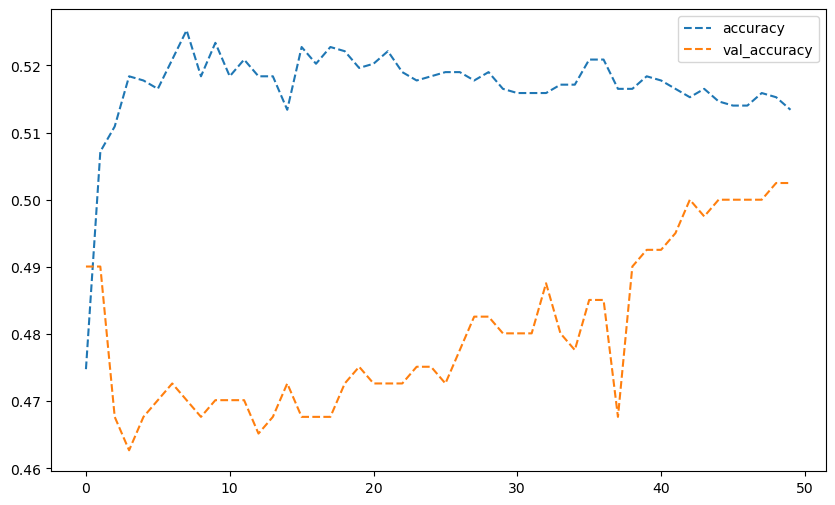

In [20]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--')

In [21]:
res.head()

,accuracy,loss,val_accuracy,val_loss
0,0.474766,0.693201,0.490050,0.693171
1,0.507165,0.693144,0.490050,0.693168
2,0.510903,0.693124,0.467662,0.693165
3,0.518380,0.693111,0.462687,0.693166
4,0.517757,0.693104,0.467662,0.693165


In [23]:
# Define threshold
threshold = 0.5

# Predict the value
pred = np.where(model.predict(training_data_[cols]) > threshold, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


return      0.826569
strategy    1.512997
dtype: float64

<Axes: xlabel='Date'>

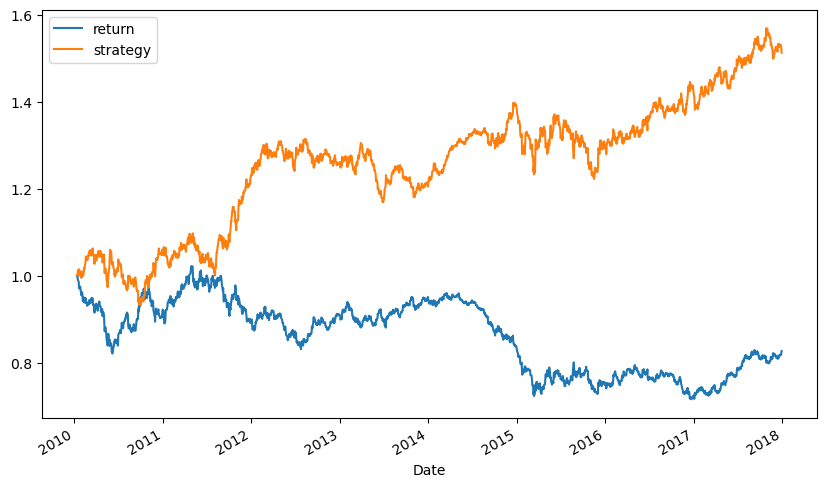

In [24]:
# Plot the result
training_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Predict the test value

In [25]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] * test_data['return'])
test_data[['return', 'strategy']].sum().apply(np.exp)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


return      0.934478
strategy    1.030635
dtype: float64

<Axes: xlabel='Date'>

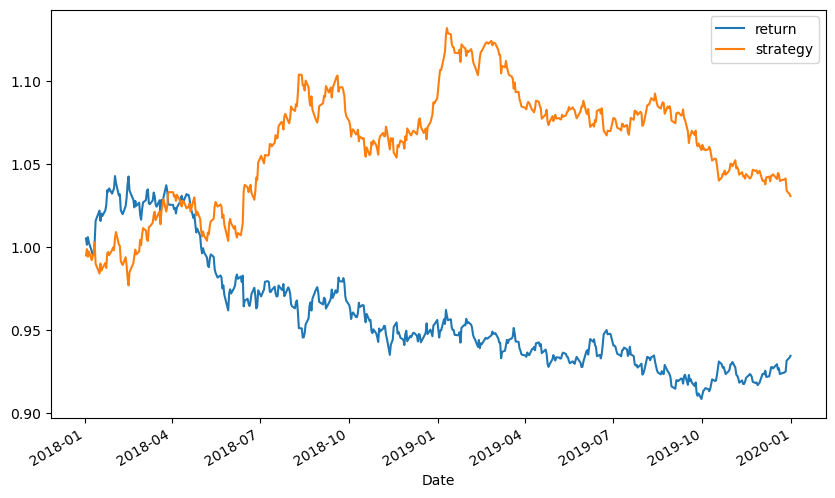

In [26]:
# Plot the gross performance
test_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6))

## Upgrade the model - Add features

I add momentum, volatility, or distance measures

In [28]:
data['momentum'] = data['return'].rolling(5).mean().shift(1)  

# Tính độ lệch chuẩn (standard deviation) của lợi suất (return) trong 20 ngày gần nhất.
data['volatility'] = data['return'].rolling(20).std().shift(1)  

# Tính khoảng cách giữa giá hiện tại và giá trung bình 50 ngày gần nhất (moving average).
# Đo mức độ "lệch" so với xu hướng dài hạn.
# Nếu distance > 0: giá đang cao hơn trung bình → có thể là dấu hiệu "quá mua" (overbought)
# Nếu distance < 0: giá đang thấp hơn trung bình → có thể là dấu hiệu "quá bán" (oversold).
data['distance'] = (data['price'] - data['price'].rolling(50).mean()).shift(1)
data.dropna(inplace=True)
data.tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2019-12-24,1.1087,0.000090,1,0.000722,-0.003784,0.000810,-0.003414,0.000628,-0.001008,0.002398,0.000458
2019-12-26,1.1096,0.000811,1,0.000090,0.000722,-0.003784,0.000810,-0.003414,-0.001115,0.002384,0.000440
2019-12-27,1.1175,0.007094,1,0.000811,0.000090,0.000722,-0.003784,0.000810,-0.000270,0.002386,0.001210
2019-12-30,1.1197,0.001967,1,0.007094,0.000811,0.000090,0.000722,-0.003784,0.000987,0.002762,0.008900
2019-12-31,1.1210,0.001160,1,0.001967,0.007094,0.000811,0.000090,0.000722,0.002137,0.002770,0.010950


In [29]:
# Add new cols to cols
cols.extend(['momentum', 'volatility', 'distance'])

### Redefine the model

In [36]:
training_data = data[data.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std
test_data = data[data.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

"""
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))  
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
"""
from tensorflow.keras import Input

model = Sequential([
    Input(shape=(len(cols),)),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

### Fit and evaluate the model

In [43]:
# Convert data to numpy instead of series, dataframe
# Keras works better with numpy
%%time
model.fit(training_data_[cols].values(), training_data['direction'].values(), verbose=True, epochs=25)

UsageError: Line magic function `%%` not found.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


<Axes: xlabel='Date'>

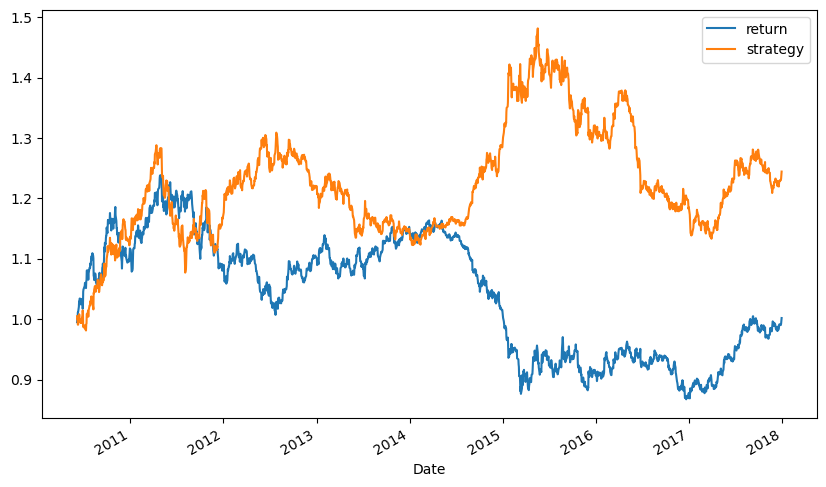

In [45]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] *
                                       training_data['return'])
training_data[['return', 'strategy']].sum().apply(np.exp)

training_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


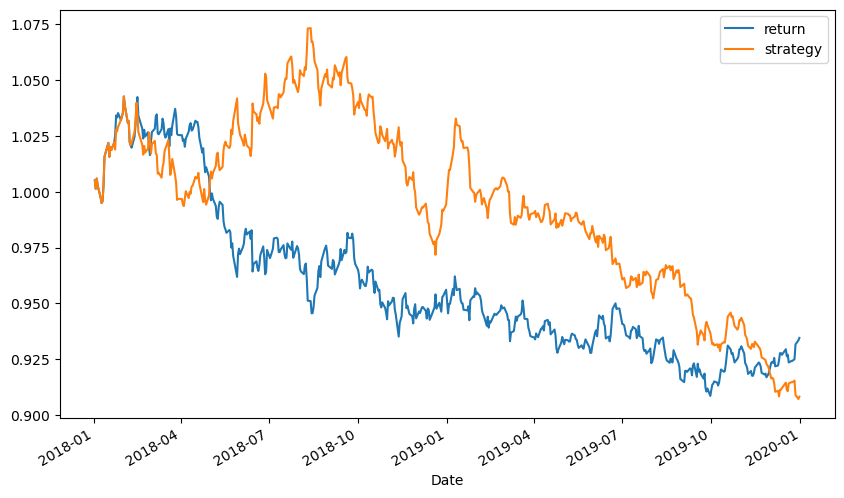

In [46]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

test_data['prediction'] = np.where(pred > 0, 1, -1)

test_data['prediction'].value_counts()

test_data['strategy'] = (test_data['prediction'] *
                                   test_data['return'])

test_data[['return', 'strategy']].sum().apply(np.exp)
test_data[['return', 'strategy']].cumsum(
                          ).apply(np.exp).plot(figsize=(10, 6));